# Machine translation using RNN
The code is taken from [PyTorch examples](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

![](https://pytorch.org/tutorials/_images/seq2seq.png)

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata



import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {} # 
        self.word2count = {} # words counter
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS


    def addSentence(self, sentence):
        # Add words splitting the sentence by space
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word):
        # Update self.word2index, self.word2count, self.n_words
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip > /dev/null

--2020-08-16 14:55:51--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.75.65, 13.249.75.87, 13.249.75.47, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.75.65|:443... connected.


HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3            0%[                    ]       0  --.-KB/s               

data.zip.3          100%[===================>]   2.75M  --.-KB/s    in 0.09s   

2020-08-16 14:55:51 (29.5 MB/s) - ‘data.zip.3’ saved [2882130/2882130]



replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

^C


In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Uncomment if data does not exists
# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip > /dev/null

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...


Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu es un idiot .', 'you re an idiot .']


In [10]:
def indexesFromSentence(lang, sentence):
    # split sentence by space and convert words to indices
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) # Special learnable layer which converts tensor of word indices to tensor of hidden size
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1, 1, self.hidden_size)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):

        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention decoder

![](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # Define your layers here: [embeeding, 2 attention networks, dropout, RNN and linear output]
#         self.embedding = ?
#         self.attn = ? # Takes [input_emb, hidden_state] and returns relevance weights of encoder outputs sequence
#         self.attn_combine = ? # Takes [input_emb, encoder_outputs_weighted_sum] and returns modified RNN input
#         self.dropout = ?
#         self.gru = ? # RNN (hidden_size,hidden_size)
#         self.out = ? # RNN output of hidden_size -> token probabilites

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
        

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1) # Weights of encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), # batch matrix-matrix product to get weighted sum of encoder outputs
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1) # [input, weighted_encoder_output]
        output = self.attn_combine(output).unsqueeze(0) # [input, weighted_encoder_output] -> [input_mod]

        output = F.relu(output)
        output, hidden = self.gru(output, hidden) # RNN on input_mod

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH,teacher_forcing_ratio=0.5):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # Initialize encoder_outputs by zeros (of shape [max_length, encoder.hidden_size])
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # update encoder_outputs
        encoder_outputs[ei] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        # pass inputs through the decoder
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        if use_teacher_forcing: # Teacher forcing: Feed the target as the next decoder input
            decoder_input = target_tensor[di]  # Teacher forcing
        else:                   # Without teacher forcing: use its own predictions as the next input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as decoder input
        loss += criterion(decoder_output, target_tensor[di])
        # Stop if terminate token (EOS) is generated
        if decoder_input.item() == EOS_token: # Terminate token is returned. Stop
            break

    # Perform gradient step
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [16]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [2]:
def TensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append("<EOS>")
    return torch.tensor(indexes, device=device).view(-1, 1)

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = TensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()


        decoded_words = input_tensor

        return decoded_words, decoder_attentions[:di + 1]

NameError: name 'MAX_LENGTH' is not defined

In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])[0]
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

2m 5s (- 29m 22s) (5000 6%) 2.8609


4m 5s (- 26m 34s) (10000 13%) 2.2745


6m 23s (- 25m 34s) (15000 20%) 1.9884


9m 16s (- 25m 30s) (20000 26%) 1.7096


12m 10s (- 24m 21s) (25000 33%) 1.4872


15m 3s (- 22m 34s) (30000 40%) 1.3340


17m 53s (- 20m 26s) (35000 46%) 1.2065


20m 44s (- 18m 8s) (40000 53%) 1.0692


23m 38s (- 15m 45s) (45000 60%) 0.9724


26m 31s (- 13m 15s) (50000 66%) 0.8817


29m 24s (- 10m 41s) (55000 73%) 0.7825


32m 22s (- 8m 5s) (60000 80%) 0.7407


34m 52s (- 5m 21s) (65000 86%) 0.6772


36m 54s (- 2m 38s) (70000 93%) 0.6090


38m 56s (- 0m 0s) (75000 100%) 0.5667


<Figure size 432x288 with 0 Axes>

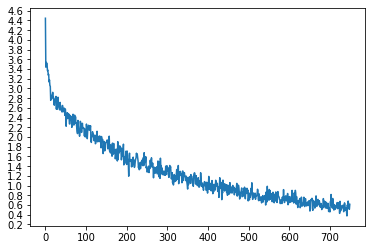

In [19]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder, decoder, 75000, print_every=5000)

In [22]:
evaluateRandomly(encoder, decoder)

> ils sont ennuyeux .
= they re boring .


TypeError: an integer is required (got type str)

## Visualizing attention

In [0]:
output_words, attentions = evaluate(
    encoder, decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [0]:

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# Transformer
En2Fr translation using transformer can be seen here [Pytorch examples](https://pytorch.org/hub/pytorch_fairseq_translation/)

In [0]:
# import torch

# # Load an En-Fr Transformer model trained on WMT'14 data :
# en2fr = torch.hub.load('pytorch/fairseq', 'transformer.wmt14.en-fr', tokenizer='moses', bpe='subword_nmt')

# # Use the GPU (optional):
# en2fr.cuda()

# # Translate with beam search:
# fr = en2fr.translate('Hello world!', beam=5)
# assert fr == 'Bonjour à tous !'

# # Manually tokenize:
# en_toks = en2fr.tokenize('Hello world!')
# assert en_toks == 'Hello world !'

# # Manually apply BPE:
# en_bpe = en2fr.apply_bpe(en_toks)
# assert en_bpe == 'H@@ ello world !'

# # Manually binarize:
# en_bin = en2fr.binarize(en_bpe)
# assert en_bin.tolist() == [329, 14044, 682, 812, 2]

# # Generate five translations with top-k sampling:
# fr_bin = en2fr.generate(en_bin, beam=5, sampling=True, sampling_topk=20)
# assert len(fr_bin) == 5

# # Convert one of the samples to a string and detokenize
# fr_sample = fr_bin[0]['tokens']
# fr_bpe = en2fr.string(fr_sample)
# fr_toks = en2fr.remove_bpe(fr_bpe)
# fr = en2fr.detokenize(fr_toks)
# assert fr == en2fr.decode(fr_sample)